In [ ]:
%matplotlib inline

import os
import numpy as np
import scipy.ndimage as nd
import skimage.morphology as morph
import skimage.segmentation as seg
import skimage.util as util
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import PIL

## HoC shape descriptor

In [6]:
def HoCS(B, min_scale, max_scale, increment, num_bins):
    '''
    Author: Mark Eramian.
    
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment: increment on which to compute scales between min_scale and 
                      max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    
    Note: a curvature values are between 0.0 and 1.0 are interpreted thusly:
       0.0 - values close to 0 arise from highly convex points.
       0.5 - no curvature
       1.0 - values close to 1 arise from highly concave points.

    This solution uses the Area Integeral Invariant from:

    Siddharth Manay, Daniel Cremers, Byung-Woo Hong, Anthony J. Yezzi and Stefano
    Soatto.  Integral Invariants for Shape Matching, IEEE Transactions on Pattern
    Analysis and Machine Intelligence, Vol 28, No. 10, pp. 1602-1618, 2006.
 
    And combines it with the curvature scale histogramming technique used in:

    Neeraj Kumar, Peter N. Belhumeur, Arijit Biswas, David W. Jacobs, W. John Kress,
    Ida Lopez, João V. B. Soares.  Leafsnap: A Computer Vision System for Automatic
    Plant Species Identification, Proceedings of the 12th European Conference on
    Computer Vision (ECCV), 2012.
    '''
    
    # Check input validity
    if max_scale < min_scale:
        raise ValueError('max_scale must be larger than min_scale')
    
    if num_bins < 1:
        raise ValueError('num_bins must be >= 1')
    
    # Assume B has only one connected component
    b_holes_filled = nd.binary_fill_holes(B)
    
    # Get the locations boundary points using the method on slide 71 of Topic 06.
    bp = np.where(seg.find_boundaries(b_holes_filled, connectivity=1, mode='inner') > 0)
    bp = np.transpose(np.vstack(bp))
    
    # iterate over scales
    histograms = []
    for radius in np.arange(min_scale, max_scale+1, increment):

        # Construct linear filter for calculating area integral invariant.
        # divide disk mask by number of 1-entries, this will respond as the 
        # percentage of 1-entries that are covering the foreground region 
        # at each pixel.
        disk = morph.disk(radius) 
        disk = disk / np.sum(disk)

        # Filter the input image -- gotta convert it to float first or the output 
        # will be boolean
        # (which is bad because all our filter responses would get rounded to zero).
        c = nd.convolve(util.img_as_float(b_holes_filled), disk)
            
        # extract the filter response for boundary pixels only.
        curvatures= c[bp[:,0], bp[:,1]]
        
        # Get the histogram of the curvatures extracted and append to the list of 
        # histograms for each scale.
        h, bin_edges = np.histogram(curvatures, bins=num_bins, range=(0.0,1.0))
        histograms.append(h/len(curvatures))
        
    # Horizontally concatenate all the histograms and return the resulting array.
    return np.hstack(histograms)

In [45]:
tiles_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod'
hocs_csv_path = tiles_path + '/hoc-prod.csv'
with open(hocs_csv_path, 'a') as csv_file:
    for i, file in enumerate(os.listdir(tiles_path)):
        # file = '244aeb_0_4096_16_80'
        if file[0:4] == 'hocs':
            continue
        print(str(i + 1) + ': ' + file)
        img_name = tiles_path + '/' + file + '/full_binary_processed.png'
        img_gs = io.imread(img_name, as_gray=True)
        img_bin = img_gs/255

        hocs_params = [5,25,10,10]
        hocs = HoCS(img_bin, *hocs_params)
        hocs_str = '\n' + file
        for p in hocs_params:
            hocs_str += ',' + str(p)
        for h in hocs:
            hocs_str += ',' + str(h)

        # print(hocs_str)
        # plt.figure(figsize=(10,6))
        # plt.ylim((0,1))
        # plt.bar(np.arange(0, len(hocs)), hocs, width=0.7)

        csv_file.write(hocs_str)
        # break
print('done')

1: 244aeb_0_4096_16_80
done


In [4]:
def lbp(B: np.ndarray) -> np.ndarray:
    """
    Computes rotationally invariant Local Binary Pattern (LBP) features for
    grayscale image B.
    
    Returns: array of two stacked histograms for LBPs with (P,R) = (8,1) and (24,3) 
    respectively.
    """
    lbp_uni_img1 = local_binary_pattern(B, 8, 1, method="uniform")
    lbp_uni_hist1 = np.histogram(lbp_uni_img1, bins=10, range=(0,9))[0] # P+2 bins
    lbp_uni_img2 = local_binary_pattern(B, 24, 3, method="uniform")
    lbp_uni_hist2 = np.histogram(lbp_uni_img2, bins=26, range=(0,25))[0] # P+2 bins
    return np.concatenate((lbp_uni_hist1, lbp_uni_hist2))

In [23]:
# tile LBP
base_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod'
lbp_csv_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod_csv/lbp-prod-tiles.csv'
with open(lbp_csv_path, 'a') as csv_file:
    for i, dir_name in enumerate(os.listdir(base_path)):
        valid_path = base_path + '/' + dir_name + '/gs/valid'
        print( '------------------', dir_name)
        for j, file in enumerate(os.listdir(valid_path)):
            if file[0] == '.': # edge case, no idea why these files exist
                continue
            tile_file = valid_path + '/' + file
            tile_name = file[:-4]
            print(str(i + 1) + ': ' + tile_name)
            img_gs = io.imread(tile_file, as_gray=True)
            img_gs = img_gs/255

#             plt.imshow(img_gs, cmap="gray", vmin=0, vmax=1)
#             plt.show()

            lbp_str = '\n' + dir_name + ',' + tile_name + ',8,1,24,3'

            lbps = lbp(img_gs)
            for l in lbps:
                lbp_str += ',' + str(l)
            
#             print(lbp_str)
#             plt.figure(figsize=(10,6))
#             plt.bar(np.arange(0, len(lbps)), lbps, width=0.7)
#             plt.show()
#             break

            csv_file.write(lbp_str)
#         break
print('done')

------------------ 21726e_0_4096_16_80
1: tile_0_0
tile_0_0
1: tile_0_4096
tile_0_4096
1: tile_0_8192
tile_0_8192
1: tile_0_12288
tile_0_12288
1: tile_20480_4096
tile_20480_4096
1: tile_20480_8192
tile_20480_8192
1: tile_20480_12288
tile_20480_12288
1: tile_24576_4096
tile_24576_4096
1: tile_24576_8192
tile_24576_8192
------------------ 4929cd_0_4096_16_80
2: tile_4096_12288
tile_4096_12288
2: tile_4096_16384
tile_4096_16384
2: tile_8192_12288
tile_8192_12288
2: tile_8192_16384
tile_8192_16384
2: tile_12288_12288
tile_12288_12288
2: tile_12288_16384
tile_12288_16384
2: tile_16384_4096
tile_16384_4096
2: tile_16384_8192
tile_16384_8192
2: tile_16384_12288
tile_16384_12288
2: tile_16384_16384
tile_16384_16384
------------------ 70c523_2_4096_16_80
3: tile_0_20480
tile_0_20480
3: tile_16384_12288
tile_16384_12288
3: tile_28672_8192
tile_28672_8192
------------------ 7633ea_0_4096_16_80
------------------ f9fc6b_1_4096_16_80
5: tile_4096_4096
tile_4096_4096
5: tile_4096_8192
tile_4096_8192

24: tile_12288_20480
tile_12288_20480
24: tile_12288_24576
tile_12288_24576
24: tile_12288_28672
tile_12288_28672
24: tile_16384_4096
tile_16384_4096
24: tile_16384_8192
tile_16384_8192
24: tile_16384_12288
tile_16384_12288
24: tile_16384_16384
tile_16384_16384
24: tile_16384_20480
tile_16384_20480
24: tile_16384_24576
tile_16384_24576
24: tile_16384_28672
tile_16384_28672
24: tile_20480_4096
tile_20480_4096
24: tile_20480_12288
tile_20480_12288
24: tile_20480_16384
tile_20480_16384
24: tile_20480_20480
tile_20480_20480
24: tile_20480_24576
tile_20480_24576
24: tile_20480_28672
tile_20480_28672
24: tile_20480_32768
tile_20480_32768
24: tile_28672_12288
tile_28672_12288
24: tile_28672_16384
tile_28672_16384
24: tile_32768_8192
tile_32768_8192
24: tile_32768_12288
tile_32768_12288
24: tile_32768_16384
tile_32768_16384
24: tile_36864_8192
tile_36864_8192
24: tile_36864_12288
tile_36864_12288
24: tile_36864_16384
tile_36864_16384
24: tile_36864_20480
tile_36864_20480
24: tile_36864_24576
t

39: tile_4096_4096
tile_4096_4096
39: tile_20480_4096
tile_20480_4096
------------------ 045eb0_0_4096_16_80
40: tile_4096_4096
tile_4096_4096
40: tile_8192_4096
tile_8192_4096
40: tile_8192_8192
tile_8192_8192
40: tile_24576_4096
tile_24576_4096
40: tile_24576_8192
tile_24576_8192
40: tile_24576_12288
tile_24576_12288
40: tile_28672_4096
tile_28672_4096
------------------ 70c523_1_4096_16_80
------------------ a45b72_0_4096_16_80
42: tile_4096_8192
tile_4096_8192
42: tile_20480_4096
tile_20480_4096
42: tile_20480_8192
tile_20480_8192
42: tile_24576_8192
tile_24576_8192
------------------ 3152c0_0_4096_16_80
43: tile_0_4096
tile_0_4096
43: tile_4096_0
tile_4096_0
43: tile_20480_4096
tile_20480_4096
43: tile_24576_0
tile_24576_0
------------------ 83cedb_0_4096_16_80
44: tile_4096_20480
tile_4096_20480
44: tile_4096_61440
tile_4096_61440
44: tile_12288_8192
tile_12288_8192
44: tile_12288_12288
tile_12288_12288
44: tile_12288_16384
tile_12288_16384
44: tile_12288_20480
tile_12288_20480
4

KeyboardInterrupt: 

1: 244aeb_0_4096_16_80


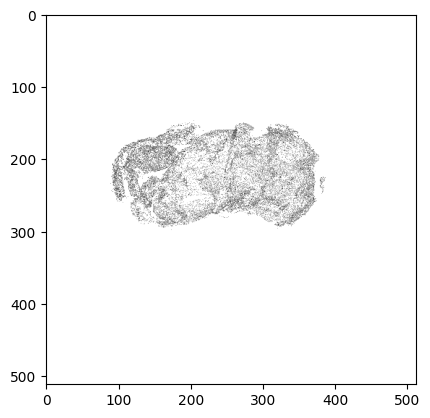

NameError: name 'lbp' is not defined

In [3]:
tiles_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod'
lbp_csv_path = tiles_path + '/lbp-prod.csv'
with open(lbp_csv_path, 'a') as csv_file:
    for i, file in enumerate(os.listdir(tiles_path)):
        file = '244aeb_0_4096_16_80'
        if file[0:3] in ['hoc', 'lbp']:
            continue
        print(str(i + 1) + ': ' + file)
        img_name = tiles_path + '/' + file + '/full_gs.png'
        img_gs = io.imread(img_name, as_gray=True)
        img_gs = img_gs/255
        
        plt.imshow(img_gs, cmap="gray", vmin=0, vmax=1)
        plt.show()

        lbp_str = '\n' + file + ',8,1,24,3'
        
        lbps = lbp(img_gs)
        for l in lbps:
            lbp_str += ',' + str(l)

        # print(lbp_str)
        # plt.figure(figsize=(10,6))
        # plt.bar(np.arange(0, len(lbps)), lbps, width=0.7)

        csv_file.write(lbp_str)
        break
print('done')

## Normalize LBP and HoC feature vectors

In [33]:
lbp_tiles_data_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod_csv/lbp-prod-tiles-sorted-data.csv'
lbp = np.genfromtxt(lbp_tiles_data_path, delimiter=',')

scaler = StandardScaler()
scaler.fit(lbp)

StandardScaler()

In [34]:
print(lbp[-5:, :])

[[1.8570e+03 1.7990e+03 7.6400e+02 9.1600e+02 6.8300e+02 1.9080e+03
  8.0700e+02 2.1220e+03 5.0749e+04 3.9310e+03 9.6400e+02 8.2700e+02
  2.3800e+02 1.3600e+02 6.6000e+01 6.8000e+01 4.3000e+01 4.9000e+01
  6.0000e+01 7.3000e+01 4.9000e+01 1.0100e+02 1.0800e+02 7.8000e+02
  1.1200e+02 7.5100e+02 1.3100e+02 7.3000e+02 1.1500e+02 1.1400e+02
  1.5700e+02 2.9700e+02 6.2300e+02 9.4900e+02 4.6815e+04 1.1180e+04]
 [2.5640e+03 2.9550e+03 1.0360e+03 1.5270e+03 8.0700e+02 2.9900e+03
  1.2700e+03 3.4810e+03 4.2126e+04 6.7800e+03 1.4520e+03 1.4340e+03
  2.5000e+02 1.1200e+02 8.4000e+01 7.2000e+01 5.2000e+01 6.7000e+01
  8.2000e+01 9.0000e+01 9.7000e+01 1.9200e+02 1.7400e+02 1.0410e+03
  2.8900e+02 1.0950e+03 2.7600e+02 1.1040e+03 2.1400e+02 2.0000e+02
  2.5300e+02 4.2600e+02 7.8000e+02 1.6900e+03 3.5791e+04 1.8219e+04]
 [2.0930e+03 2.1470e+03 1.0430e+03 1.8160e+03 1.1580e+03 2.9510e+03
  1.2620e+03 2.8580e+03 4.5456e+04 4.7520e+03 9.8100e+02 7.6700e+02
  4.1200e+02 2.2100e+02 1.6600e+02 1.3300e+02 

In [35]:
scaler.mean_

array([ 3543.9287408 ,  3533.96617996,  1248.30912268,  1701.61712218,
        1111.26257332,  2770.53325846,  1557.11481343,  4043.87757394,
       37971.21552477,  8054.17509048,  1965.48184201,  1696.06514414,
         405.5087982 ,   169.10383127,    94.41669787,    75.99775365,
          55.89080245,    67.07749906,    81.22563335,    97.30912268,
         116.50330713,   203.27343068,   218.97129664,   838.62411082,
         234.64233121,   825.31523774,   220.17796081,   800.61724697,
         164.6248596 ,   193.42905279,   252.53263447,   495.42181455,
        1032.89804068,  1986.34156995, 32042.89205042, 21201.65793086])

In [36]:
scaler.var_

array([2.95931683e+06, 2.07456241e+06, 3.34546132e+05, 4.01731647e+05,
       3.59457000e+05, 6.11123828e+05, 4.08182874e+05, 2.17767880e+06,
       1.01142232e+08, 1.11681318e+07, 9.83020637e+05, 6.26249463e+05,
       3.92154135e+04, 6.16814771e+03, 1.92392707e+03, 1.44348808e+03,
       1.22190858e+03, 2.04439896e+03, 3.45401398e+03, 7.33981247e+03,
       1.47896465e+04, 5.43827071e+04, 1.37325679e+05, 1.54052475e+05,
       3.50884843e+04, 5.22579872e+04, 1.26864054e+04, 4.53895993e+04,
       5.70564187e+03, 6.52411193e+03, 1.14189386e+04, 7.27478972e+04,
       4.64023097e+05, 4.73158156e+05, 1.15808163e+08, 7.02416406e+07])

In [37]:
lbp_norm = scaler.transform(lbp)

In [38]:
print(lbp_norm)

[[ 0.05817195 -0.39432946 -0.22702145 ... -0.36394001  0.4486497
  -0.29121222]
 [-0.80564769 -0.88241065 -0.8528863  ... -0.62271175  0.83660965
  -0.82145739]
 [ 0.05526542  0.10000028  0.05651953 ...  0.46034973 -0.19671122
   0.09442064]
 ...
 [-0.84343254 -0.96294752 -0.35496067 ... -1.10100332  0.78308512
  -0.79019632]
 [-0.63474394 -0.63663435 -0.38780993 ... -0.62852684  0.54352566
  -0.49357401]
 [ 0.0302693   0.20553135  0.22422365 ... -0.0150343  -0.1038796
   0.20001627]]


In [39]:
lbp_norm_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod_csv/lbp-prod-tiles-sorted-data-norm.csv'
np.savetxt(lbp_norm_path, lbp_norm, delimiter=",")

In [ ]:
hoc_data_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod/hoc-prod-sorted-data.csv'
hoc = np.genfromtxt(hoc_data_path, delimiter=',')

scaler = StandardScaler()
scaler.fit(hoc)

StandardScaler()

In [ ]:
scaler.mean_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.34859264e-02,
       2.00899195e-01, 5.58139153e-01, 2.15374836e-01, 1.20705227e-02,
       3.03671329e-05, 0.00000000e+00, 1.69751637e-03, 7.10875998e-03,
       2.51198902e-02, 8.24551738e-02, 3.57967518e-01, 3.99051677e-01,
       8.99443735e-02, 3.13797428e-02, 5.23673238e-03, 3.86158210e-05,
       6.47236219e-03, 1.62713427e-02, 4.44037184e-02, 1.15012735e-01,
       3.79599748e-01, 3.01402303e-01, 8.65703161e-02, 3.83579328e-02,
       1.17743530e-02, 1.35189223e-04])

In [ ]:
scaler.var_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38323856e-04,
       1.74875171e-03, 5.21514404e-03, 7.02272513e-04, 2.15012773e-05,
       7.82520108e-09, 0.00000000e+00, 2.04108893e-05, 2.96092465e-04,
       6.71018932e-04, 1.82382787e-03, 2.02597075e-03, 7.23952668e-03,
       5.56225278e-04, 1.89634025e-04, 1.79691661e-05, 1.19378906e-07,
       4.56245249e-04, 8.83555748e-04, 1.73342236e-03, 2.52227296e-03,
       4.69506526e-03, 6.36232503e-03, 6.88944927e-04, 3.31029651e-04,
       7.09600943e-05, 4.63637951e-07])

In [ ]:
hoc_norm = scaler.transform(hoc)

In [ ]:
print(hoc_norm)

[[ 0.          0.          0.         ...  0.98383745  0.93890931
  -0.03183112]
 [ 0.          0.          0.         ... -0.14927666 -0.33997355
  -0.19854209]
 [ 0.          0.          0.         ... -0.32671214  0.05665374
  -0.19854209]
 ...
 [ 0.          0.          0.         ... -0.34142561 -0.57264961
  -0.19854209]
 [ 0.          0.          0.         ...  0.64272306  0.20719674
  -0.19854209]
 [ 0.          0.          0.         ...  0.87097076  0.18888863
  -0.19854209]]


In [ ]:
hoc_norm_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod/hoc-prod-sorted-data-norm.csv'
np.savetxt(hoc_norm_path, hoc_norm, delimiter=",")

### Generate histograms for presentation

In [9]:
hoc_data_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod/hoc-prod-sorted-data.csv'
hoc = np.genfromtxt(hoc_data_path, delimiter=',')

<BarContainer object of 30 artists>

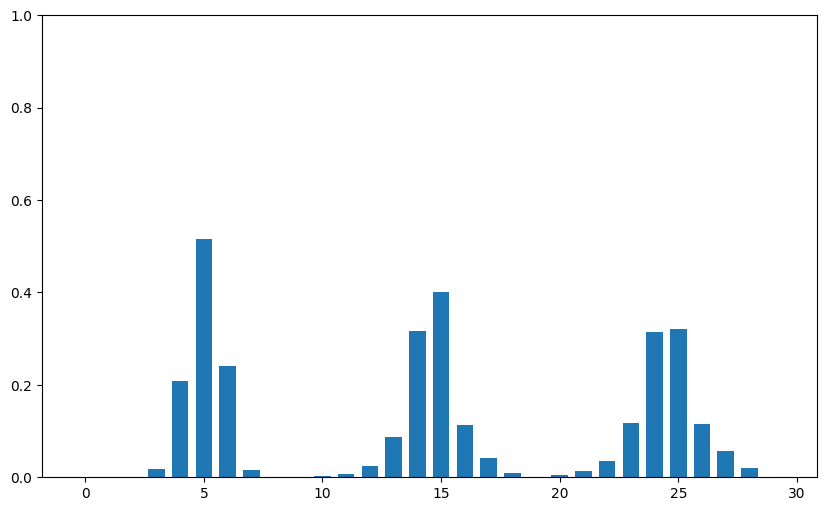

In [11]:
plt.figure(figsize=(10,6))
plt.ylim((0,1))
plt.bar(np.arange(0, len(hoc[0])), hoc[0], width=0.7)

<BarContainer object of 36 artists>

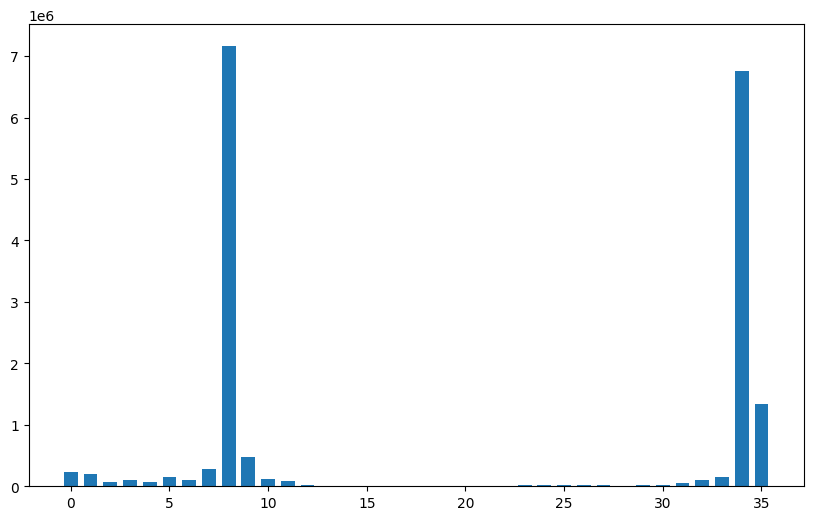

In [12]:
lbp_data_path = '/Volumes/Extreme SSD/cmpt400/tiles_prod/lbp-prod-sorted-data.csv'
lbp = np.genfromtxt(lbp_data_path, delimiter=',')
plt.figure(figsize=(10,6))
plt.bar(np.arange(0, len(lbp[0])), lbp[0], width=0.7)